# Team Strength Analysis

We want to figure out a way to measure the strength of a team over the course of a season, so that we can factor it into future analyses and models. Eventually, it would be good to have a model of a team's strength that can change from GW to GW, but right now we will focus our efforts on figuring out an aggregate metric, i.e. that measures the average strength of the team over a season. The strength of a team is broken down into attacking and defensive strength. Ultimately, the way we'll measure attacking strength is goals scored over the whole season, and defensive by goals conceded over the whole season. Therefore, we want to find a metric that's highly correlated with the total goals scored and conceded over the season. This metric will probably be separate for home and away fixtures, as home fixtures give a team a greater chance of winning a match.

There are a number of metrics available to measure the strength of a team in FPL:

1. **Fixture Difficulty Rating (FDR):** The FDR is based on a complex algorithm developed by FPL experts. A set of formulas process key Opta data variables, along with each team's home and away form for the past six matches, to generate a rank for the perceived difficulty of each Gameweek opponent. The FDR is designed to help FPL managers plan their transfer and team selection strategy. It is reviewed on a weekly basis and updated as the season progresses.

From our dataset, we also have a file called `teams.csv`, which is uploaded at the start of the season and is not updated as the season progresses. In this file, the following metrics are available:

2. **Strength overall home:** Continuous variable. Average of **Strength attack home** and **Strength defence home**.

3. **Strength overall away:** Continuous variable. Average of **Strength attack away** and **Strength defence away**.

We will carry out this analysis with the data from last season (2022/23), as we don't know how the FDR has changed in recent years - i.e. it's possible it has improved over the past few seasons as more data becomes available.

# Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, pearsonr

# 1. Fixture Difficulty Rating

## Read data:

In [2]:
fixtures_path = '../data/Fantasy-Premier-League/data/2022-23/fixtures.csv'
fixtures = pd.read_csv(fixtures_path)
fixtures

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2292810,1,True,True,1,2022-08-05T19:00:00Z,90,False,True,1,2,7,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,2,74911
1,2292813,1,True,True,4,2022-08-06T11:30:00Z,90,False,True,12,2,9,2,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,2,74914
2,2292811,1,True,True,2,2022-08-06T14:00:00Z,90,False,True,2,0,3,2,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,2,74912
3,2292814,1,True,True,5,2022-08-06T14:00:00Z,90,False,True,20,1,11,2,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,74915
4,2292816,1,True,True,7,2022-08-06T14:00:00Z,90,False,True,16,0,15,2,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,4,74917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2293185,38,True,True,376,2023-05-28T15:30:00Z,90,False,True,3,0,8,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,2,75286
376,2293186,38,True,True,377,2023-05-28T15:30:00Z,90,False,True,18,4,11,1,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,2,75287
377,2293187,38,True,True,378,2023-05-28T15:30:00Z,90,False,True,19,1,10,2,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,3,75288
378,2293188,38,True,True,379,2023-05-28T15:30:00Z,90,False,True,9,1,14,2,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,4,75289


In [3]:
teams_path = '../data/Fantasy-Premier-League/data/2022-23/teams.csv'
teams = pd.read_csv(teams_path)
teams

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,...,NaN,False,0,1245,1285,1250,1250,1240,1320,1
1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,...,NaN,False,0,1070,1100,1070,1075,1070,1130,2
2,91,0,NaN,3,0,Bournemouth,0,0,0,BOU,...,NaN,False,0,1035,1095,1020,1110,1050,1080,127
3,94,0,NaN,4,0,Brentford,0,0,0,BRE,...,NaN,False,0,1115,1180,1100,1160,1130,1200,130
4,36,0,NaN,5,0,Brighton,0,0,0,BHA,...,NaN,False,0,1170,1175,1140,1150,1200,1200,131
5,8,0,NaN,6,0,Chelsea,0,0,0,CHE,...,NaN,False,0,1165,1220,1190,1220,1140,1220,4
6,31,0,NaN,7,0,Crystal Palace,0,0,0,CRY,...,NaN,False,0,1085,1100,1110,1110,1060,1090,6
7,11,0,NaN,8,0,Everton,0,0,0,EVE,...,NaN,False,0,1055,1095,1070,1100,1040,1090,7
8,54,0,NaN,9,0,Fulham,0,0,0,FUL,...,NaN,False,0,1095,1100,1070,1065,1120,1140,34
9,13,0,NaN,10,0,Leicester,0,0,0,LEI,...,NaN,False,0,1130,1115,1065,1110,1200,1120,26


In [4]:
away_data = fixtures.loc[:,['team_a','team_a_score','team_h_score','team_h_difficulty']]
team_name_map = dict(zip(teams.id,teams.short_name))
away_data.team_a = away_data.team_a.map(team_name_map)
away_data.rename(columns={'team_a':'name','team_a_score':'goals_scored','team_h_score':'goals_conceded','team_h_difficulty':'FDR_rank'},inplace=True)
away_data

,name,goals_scored,goals_conceded,FDR_rank
0,ARS,2,0,4
1,LIV,2,2,4
2,AVL,0,2,2
3,WOL,1,2,2
4,NFO,0,2,2
...,...,...,...,...
375,BOU,0,1,2
376,TOT,4,1,3
377,WHU,1,2,2
378,FUL,1,2,2


In [5]:
home_data = fixtures.loc[:,['team_h','team_h_score','team_a_score','team_a_difficulty']]
home_data.team_h = home_data.team_h.map(team_name_map)
home_data.rename(columns={'team_h':'name','team_h_score':'goals_scored','team_a_score':'goals_conceded','team_a_difficulty':'FDR_rank'},inplace=True)
home_data

,name,goals_scored,goals_conceded,FDR_rank
0,CRY,0,2,2
1,FUL,2,2,2
2,BOU,2,0,2
3,LEE,2,1,2
4,NEW,2,0,4
...,...,...,...,...
375,EVE,1,0,2
376,LEE,1,4,2
377,LEI,2,1,3
378,MUN,2,1,4


In [6]:
home_data.loc[:,['name','FDR_rank']].groupby('name').value_counts()

name  FDR_rank
ARS   4           19
AVL   2           19
BHA   3           19
BOU   2           19
BRE   3           19
CHE   4           19
CRY   2           19
EVE   2           19
FUL   2           19
LEE   2           19
LEI   3           19
LIV   4           19
MCI   5           19
MUN   4           19
NEW   4           19
NFO   2           19
SOU   2           19
TOT   4           19
WHU   3           19
WOL   2           19
Name: count, dtype: int64

In [7]:
away_data.loc[:,['name','FDR_rank']].groupby('name').value_counts()

name  FDR_rank
ARS   4           19
AVL   2           19
BHA   3           19
BOU   2           19
BRE   3           19
CHE   3           19
CRY   2           19
EVE   2           19
FUL   2           19
LEE   2           19
LEI   3           19
LIV   4           19
MCI   5           19
MUN   3           19
NEW   3           19
NFO   2           19
SOU   2           19
TOT   3           19
WHU   2           19
WOL   2           19
Name: count, dtype: int64

So each team has an FDR rank for home and for away, which doesn't seem to change throughout the season. In some cases, the team's rank is the same for both home and away (e.g. Arsenal, Man City). So let's group by name and take the mean of goals scored, goals conceded and rank. Since rank is fixed for home and away, it won't change, and the mean of goals scored and goals conceded is the average goals scored/conceded per match

In [8]:
home_data = home_data.groupby(by='name').mean()
home_data.FDR_rank = home_data.FDR_rank.astype(int)
home_data

,goals_scored,goals_conceded,FDR_rank
name,,,
ARS,2.789474,1.315789,4
AVL,1.736842,1.105263,2
BHA,1.947368,1.105263,3
BOU,1.052632,1.473684,2
BRE,1.842105,0.947368,3
CHE,1.052632,1.000000,4
CRY,1.105263,1.210526,2
EVE,0.842105,1.421053,2
FUL,1.631579,1.526316,2


In [9]:
away_data = away_data.groupby(by='name').mean()
away_data.FDR_rank = away_data.FDR_rank.astype(int)
away_data

,goals_scored,goals_conceded,FDR_rank
name,,,
ARS,1.842105,0.947368,4
AVL,0.947368,1.315789,2
BHA,1.842105,1.684211,3
BOU,0.894737,2.263158,2
BRE,1.210526,1.473684,3
CHE,0.947368,1.473684,3
CRY,1.000000,1.368421,2
EVE,0.947368,1.578947,2
FUL,1.263158,1.263158,2


## Measuring Attacking and Defensive Strength at Home with FDR:

We will visualise the relationship with boxplots, before calculating Kendall's tau coefficient to measure the correlation between home goals scored & home goals conceded and the FDR rank. Using Kendall's tau-b as the FDR rank is an ordinal variable (rank from 1 to 5) and the average goals scored/conceded is a numeric variable.

### Visualising the relationship

In [10]:
ranks = sorted(home_data.FDR_rank.unique())
goals_scored = []
goals_conceded = []
for rank in ranks:
    goals_scored.append(home_data.loc[home_data.FDR_rank == rank,'goals_scored'].values)
    goals_conceded.append(home_data.loc[home_data.FDR_rank == rank,'goals_conceded'].values)

C:\Users\Development\AppData\Local\Temp\ipykernel_11512\729198216.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\729198216.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


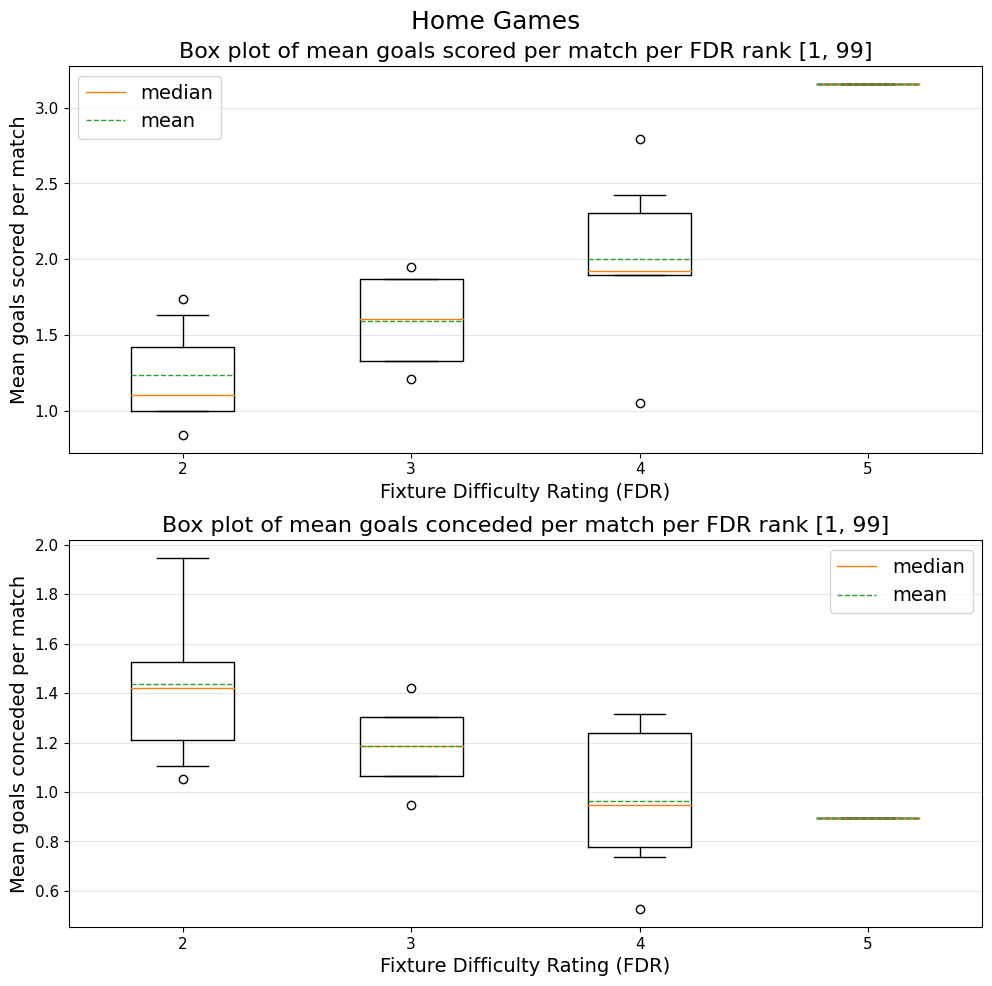

In [11]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

box_dict = ax[0].boxplot(goals_scored, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
#ax[0].set_yticks(range(home_data.goals_scored.max()+1))
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[0].grid(axis = 'y', alpha = 0.3)
ax[0].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[0].set_title('''Box plot of mean goals scored per match per FDR rank [1, 99]''', fontsize = axis_title_font)

box_dict = ax[1].boxplot(goals_conceded, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
#ax[1].set_yticks(range(home_away_data.goals_conceded.max()+1))
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[1].grid(axis = 'y', alpha = 0.3)
ax[1].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[1].set_title('''Box plot of mean goals conceded per match per FDR rank [1, 99]''', fontsize = axis_title_font)

fig.suptitle('Home Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/FDR_goals_scored_conceded_home_boxplots.png', bbox_inches = 'tight')
plt.show()

### Measuring the correlation beween FDR and goals scored/conceded

In [12]:
result = kendalltau(home_data.FDR_rank, home_data.goals_scored, variant = 'b')
print(f'''Correlation between a team's home FDR and home goals scored: {result.statistic}''')

result = kendalltau(home_data.FDR_rank, home_data.goals_conceded, variant = 'b')
print(f'''Correlation between a team's FDR and goals conceded: {result.statistic}''')

Correlation between a team's home FDR and home goals scored: 0.599261212844002
Correlation between a team's FDR and goals conceded: -0.5050011409267955


## Measuring Attacking and Defensive Strength Away with FDR:

### Visualising the relationship

In [13]:
ranks = sorted(away_data.FDR_rank.unique())
goals_scored = []
goals_conceded = []
for rank in ranks:
    goals_scored.append(away_data.loc[away_data.FDR_rank == rank,'goals_scored'].values)
    goals_conceded.append(away_data.loc[away_data.FDR_rank == rank,'goals_conceded'].values)

C:\Users\Development\AppData\Local\Temp\ipykernel_11512\1085394171.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\1085394171.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


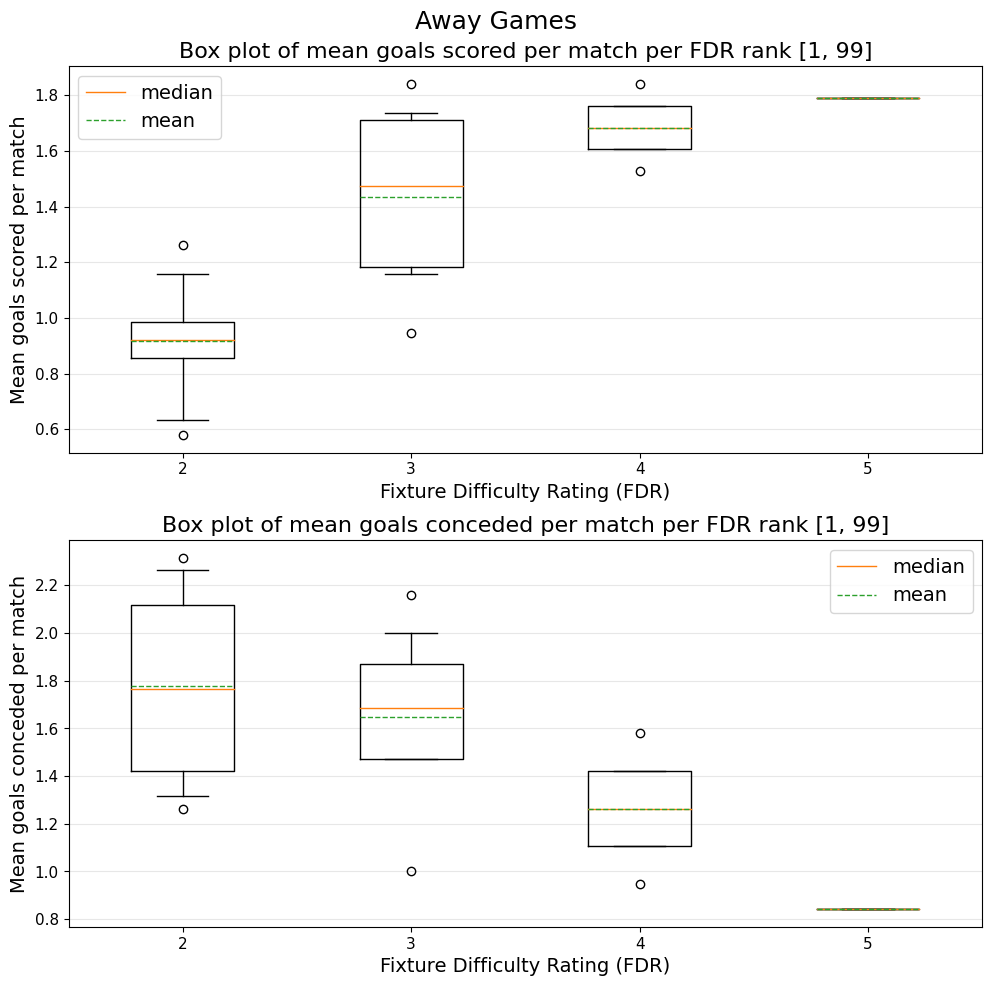

In [14]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

box_dict = ax[0].boxplot(goals_scored, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
#ax[0].set_yticks(range(home_data.goals_scored.max()+1))
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[0].grid(axis = 'y', alpha = 0.3)
ax[0].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[0].set_title('''Box plot of mean goals scored per match per FDR rank [1, 99]''', fontsize = axis_title_font)

box_dict = ax[1].boxplot(goals_conceded, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
#ax[1].set_yticks(range(home_away_data.goals_conceded.max()+1))
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[1].grid(axis = 'y', alpha = 0.3)
ax[1].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[1].set_title('''Box plot of mean goals conceded per match per FDR rank [1, 99]''', fontsize = axis_title_font)

fig.suptitle('Away Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/FDR_goals_scored_conceded_away_boxplots.png', bbox_inches = 'tight')
plt.show()

## Measuring the correlation beween FDR and goals scored/conceded

In [15]:
result = kendalltau(away_data.FDR_rank, away_data.goals_scored, variant = 'b')
print(f'''Correlation between a team's away FDR and away goals scored: {result.statistic}''')

result = kendalltau(away_data.FDR_rank, away_data.goals_conceded, variant = 'b')
print(f'''Correlation between a team's FDR and goals conceded: {result.statistic}''')

Correlation between a team's away FDR and away goals scored: 0.6580724769671464
Correlation between a team's FDR and goals conceded: -0.3305681265658414


So the correlation between home goals scored and FDR is weaker than for away goals scored and FDR. The reverse is true for goals conceded: the correlation is stronger at home than away.

# 2. Strength at home

Since mean goals scored/conceded per match is a continuous numeric variable and the strength metric is a discrete numeric variable, we'll use Pearson's correlation coefficient to measure the strength of the relationship.

In [16]:
home_data = home_data.merge(teams.loc[:,['short_name','strength_attack_home','strength_defence_home']], how = 'inner', left_on = 'name', right_on = 'short_name')
home_data

,goals_scored,goals_conceded,FDR_rank,short_name,strength_attack_home,strength_defence_home
0,2.789474,1.315789,4,ARS,1250,1240
1,1.736842,1.105263,2,AVL,1070,1070
2,1.947368,1.105263,3,BHA,1140,1200
3,1.052632,1.473684,2,BOU,1020,1050
4,1.842105,0.947368,3,BRE,1100,1130
5,1.052632,1.000000,4,CHE,1190,1140
6,1.105263,1.210526,2,CRY,1110,1060
7,0.842105,1.421053,2,EVE,1070,1040
8,1.631579,1.526316,2,FUL,1070,1120
9,1.368421,1.947368,2,LEE,1070,1130


## Visualising the relationship

C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4100843809.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4100843809.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4100843809.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4100843809.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


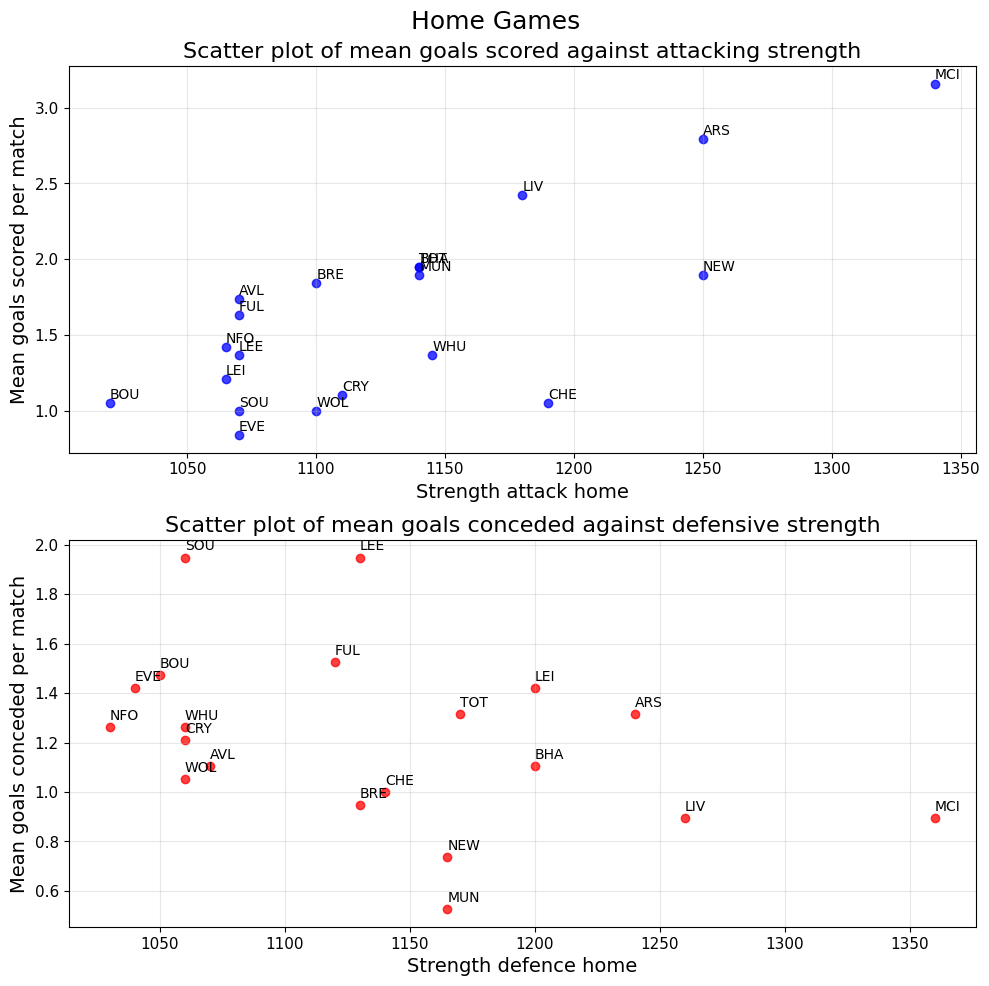

In [25]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

ax[0].scatter(home_data.strength_attack_home, home_data.goals_scored, alpha = 0.75, color='b')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
#ax[0].set_yticks(range(home_data.goals_scored.max()+1))
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Strength attack home', fontsize = axis_label_font)
ax[0].grid(alpha = 0.3)
ax[0].set_title('''Scatter plot of mean goals scored against attacking strength''', fontsize = axis_title_font)
for i, txt in enumerate(home_data.short_name):
    ax[0].annotate(txt, (home_data.strength_attack_home[i], home_data.goals_scored[i]), (home_data.strength_attack_home[i]+0.03, home_data.goals_scored[i]+0.03))

ax[1].scatter(home_data.strength_defence_home, home_data.goals_conceded, alpha = 0.75, color='r')
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
#ax[0].set_yticks(range(home_data.goals_scored.max()+1))
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Strength defence home', fontsize = axis_label_font)
ax[1].grid(alpha = 0.3)
ax[1].set_title('''Scatter plot of mean goals conceded against defensive strength''', fontsize = axis_title_font)
for i, txt in enumerate(home_data.short_name):
    ax[1].annotate(txt, (home_data.strength_defence_home[i], home_data.goals_conceded[i]), (home_data.strength_defence_home[i]+0.03, home_data.goals_conceded[i]+0.03))

fig.suptitle('Home Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/home_attack_defence_scatter.png', bbox_inches = 'tight')
plt.show()

## Measuring the Correlation between strength and goals scored/conceded

In [27]:
result = pearsonr(home_data.strength_attack_home, home_data.goals_scored)
print(f'''Correlation between a team's home attacking strength and home goals scored: {result.statistic}''')

result = pearsonr(home_data.strength_defence_home, home_data.goals_conceded)
print(f'''Correlation between a team's home defensive strength and goals conceded: {result.statistic}''')

Correlation between a team's home attacking strength and home goals scored: 0.7660920232037528
Correlation between a team's home defensive strength and goals conceded: -0.3743022454372481


# 3. Strength Away

In [28]:
away_data = away_data.merge(teams.loc[:,['short_name','strength_attack_away','strength_defence_away']], how = 'inner', left_on = 'name', right_on = 'short_name')
away_data

,goals_scored,goals_conceded,FDR_rank,short_name,strength_attack_away,strength_defence_away
0,1.842105,0.947368,4,ARS,1250,1320
1,0.947368,1.315789,2,AVL,1075,1130
2,1.842105,1.684211,3,BHA,1150,1200
3,0.894737,2.263158,2,BOU,1110,1080
4,1.210526,1.473684,3,BRE,1160,1200
5,0.947368,1.473684,3,CHE,1220,1220
6,1.000000,1.368421,2,CRY,1110,1090
7,0.947368,1.578947,2,EVE,1100,1090
8,1.263158,1.263158,2,FUL,1065,1140
9,1.157895,2.157895,2,LEE,1075,1120


## Visualising the relationship

C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4159960420.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4159960420.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4159960420.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_11512\4159960420.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


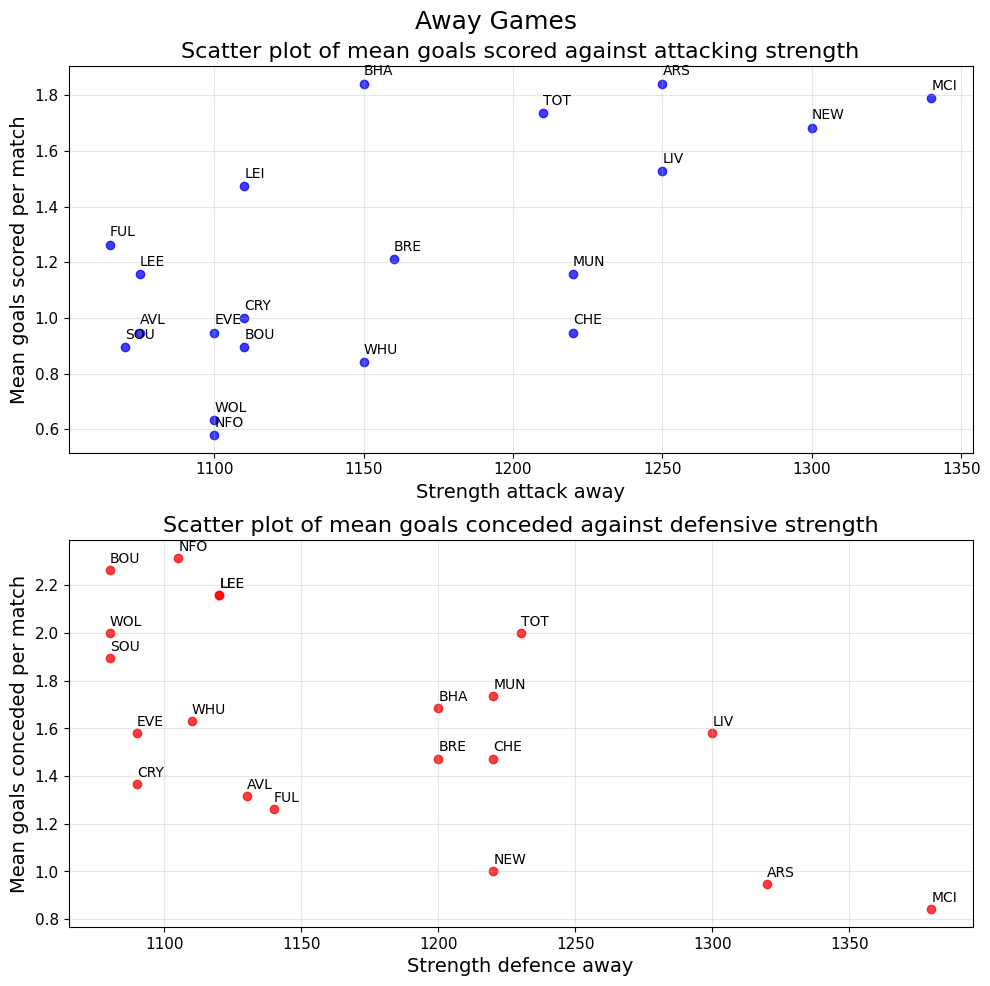

In [29]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

ax[0].scatter(away_data.strength_attack_away, away_data.goals_scored, alpha = 0.75, color='b')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Strength attack away', fontsize = axis_label_font)
ax[0].grid(alpha = 0.3)
ax[0].set_title('''Scatter plot of mean goals scored against attacking strength''', fontsize = axis_title_font)
for i, txt in enumerate(away_data.short_name):
    ax[0].annotate(txt, (away_data.strength_attack_away[i], away_data.goals_scored[i]), (away_data.strength_attack_away[i]+0.03, away_data.goals_scored[i]+0.03))

ax[1].scatter(away_data.strength_defence_away, away_data.goals_conceded, alpha = 0.75, color='r')
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Strength defence away', fontsize = axis_label_font)
ax[1].grid(alpha = 0.3)
ax[1].set_title('''Scatter plot of mean goals conceded against defensive strength''', fontsize = axis_title_font)
for i, txt in enumerate(away_data.short_name):
    ax[1].annotate(txt, (away_data.strength_defence_away[i], away_data.goals_conceded[i]), (away_data.strength_defence_away[i]+0.03, away_data.goals_conceded[i]+0.03))

fig.suptitle('Away Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/away_attack_defence_scatter.png', bbox_inches = 'tight')
plt.show()

## Correlation

In [30]:
result = pearsonr(away_data.strength_attack_away, away_data.goals_scored)
print(f'''Correlation between a team's away attacking strength and away goals scored: {result.statistic}''')

result = pearsonr(away_data.strength_defence_away, away_data.goals_conceded)
print(f'''Correlation between a team's away defensive strength and goals conceded: {result.statistic}''')

Correlation between a team's away attacking strength and away goals scored: 0.6519681925265824
Correlation between a team's away defensive strength and goals conceded: -0.6160616999198463
